## 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page [ VLM Multitask - V1 ]
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms.
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

**Model**: `vlm.multitask.v1`
**Model Description**: This multitask VLM is designed to handle, among others, three primary functions: performing OCR, detecting text and applying OCR, and extracting data from both general and medical invoices. For medical invoices, the model can first determine whether the document is medical before extracting the relevant information.

In [ ]:
model_package_arn = "<Customer to specify Model package ARN corresponding to their AWS region>"

In [ ]:
import base64
import shutil
import json
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
import boto3
from IPython.display import Image, display, IFrame
from PIL import Image as ImagePil
from urllib.parse import urlparse
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

sagemaker_session = sage.Session()
s3_bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role = get_execution_role()

sagemaker = boto3.client("sagemaker")
s3_client = sagemaker_session.boto_session.client("s3")
ecr = boto3.client("ecr")
sm_runtime = boto3.client("sagemaker-runtime")

In [ ]:
model_name = "vlm-multitask-v1"

real_time_inference_instance_type = "ml.c5.9xlarge"
batch_transform_inference_instance_type = "ml.c5.9xlarge"

## 2. Create a deployable model from the model package.

In [ ]:
# create a deployable model from the model package.
model = ModelPackage(
    role=role, model_package_arn=model_package_arn, sagemaker_session=sagemaker_session
)

----------------!

## 3. Create an SageMaker Endpoint

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [ ]:
# Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

### 3.1 Real-time inference via Amazon SageMaker Endpoint

In [ ]:
def process_data_and_invoke_realtime_endpoint(pdf_file, task, content_type="application/json"):
    with open(pdf_file, "rb") as file:
        pdf_data = file.read()

    # Encode PDF as base64 string
    encoded_data = base64.b64encode(pdf_data).decode("utf-8")

    payload = {
        "data": encoded_data,
        "task": task  # dynamic task
    }

    i = 1
    input_extension = os.path.splitext(pdf_file)[-1]
    input_file_name = f'inputs/real-time/input{i}{input_extension}'

    while os.path.exists(input_file_name):
        i += 1
        input_file_name = f'inputs/real-time/input{i}{input_extension}'

    output_file_name = f'outputs/real-time/{os.path.basename(input_file_name)}.out'

    os.makedirs(os.path.dirname(input_file_name), exist_ok=True)
    os.makedirs(os.path.dirname(output_file_name), exist_ok=True)

    shutil.copy2(pdf_file, input_file_name)

    # Upload original file to S3 for traceability
    validation_input_file_path = f"{model_name}/validation-input/real-time/{os.path.basename(input_file_name)}"
    s3_client.upload_file(pdf_file, s3_bucket, validation_input_file_path)

    # Call SageMaker endpoint with JSON payload
    response = sm_runtime.invoke_endpoint(
        EndpointName=model_name,
        ContentType="application/json",
        Accept="application/json",
        Body=json.dumps(payload)
    )

    # Process response
    response_data = json.loads(response["Body"].read().decode("utf-8"))

    # Save response locally and to S3
    s3_client.put_object(
        Bucket=s3_bucket,
        Key=f"{model_name}/validation-output/real-time/{os.path.basename(output_file_name)}",
        Body=json.dumps(response_data).encode("utf-8")
    )
    with open(output_file_name, 'w') as f_out:
        json.dump(response_data, f_out, indent=4)

    return response_data

### Download Images

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/visual-nlp-workshop/master/jupyter/data/endpoints_files/input_handwritten_1.jpg
!wget https://raw.githubusercontent.com/JohnSnowLabs/visual-nlp-workshop/master/jupyter/data/endpoints_files/input_ocr_2.png
!wget https://raw.githubusercontent.com/JohnSnowLabs/visual-nlp-workshop/master/jupyter/data/endpoints_files/input_invoice_4.jpg
!wget https://raw.githubusercontent.com/JohnSnowLabs/visual-nlp-workshop/master/jupyter/data/endpoints_files/input_invoice_5.png

#### Example 1 - OCR in Multi Page Document

In [ ]:
image_paths = ['../input_handwritten_1.jpg', '../input_ocr_2.png']

images = [ImagePil.open(img_path).convert('RGB') for img_path in image_paths]

pdf_path = 'input_1.pdf'
images[0].save(pdf_path, save_all=True, append_images=images[1:])

In [ ]:
IFrame("./input_1.pdf", width=1000, height=800)

In [ ]:
# Example run
data = process_data_and_invoke_realtime_endpoint(
    pdf_file='./input_1.pdf',
    task='<OCR>'
)

In [ ]:
data

{'pages': [{'page': 1,
   'text': {'<OCR>': "This is an example of handwritten\nbest.\nLet's oe check the performance!\nI hope it will be awesome.\n"}},
  {'page': 2,
   'text': {'<OCR>': 'STARBUCKS Store #10208\n11302 Euclid Avenue\nCleveland, OH (216) 229-0749\nCHK 664290\n12/07/2014 06:43 PM\n1912003 Drawer: 2 Reg: 2\nVt Pep Mocha\n4.95\nShux Card\n4,95\nXXXXXXXXXXXXX3228\nSubtotal\n$4.96\nTotal\n$44.95.\nChange Due\n$0.00\nCheck Closed\n12 /07/ 2014 06: 43 PM\nSBUX Card x3228 New Balance: 37.45\nCard is registertal.\n'}}]}

#### Example 2 - Text Detection and OCR in Single Page Document

In [ ]:
image_paths = ['../input_ocr_2.png']

images = [ImagePil.open(img_path).convert('RGB') for img_path in image_paths]

pdf_path = 'input_2.pdf'
images[0].save(pdf_path, save_all=True)

In [ ]:
IFrame("./input_2.pdf", width=1000, height=800)

In [ ]:
data = process_data_and_invoke_realtime_endpoint(
    pdf_file='./input_2.pdf',
    task='<OCR_WITH_REGION>'
)

In [ ]:
data

{'pages': [{'page': 1,
   'text': {'<OCR_WITH_REGION>': {'quad_boxes': [[583.2124633789062,
       122.44999694824219,
       1815.1124267578125,
       122.44999694824219,
       1815.1124267578125,
       237.14999389648438,
       583.2124633789062,
       237.14999389648438],
      [653.5374755859375,
       261.9499816894531,
       1701.137451171875,
       271.25,
       1701.137451171875,
       379.75,
       653.5374755859375,
       370.4499816894531],
      [415.8874816894531,
       398.3499755859375,
       1984.8624267578125,
       398.3499755859375,
       1984.8624267578125,
       516.1499633789062,
       415.8874816894531,
       516.1499633789062],
      [917.8624877929688,
       674.25,
       1480.4625244140625,
       674.25,
       1480.4625244140625,
       782.75,
       917.8624877929688,
       782.75],
      [648.6875,
       807.5499877929688,
       1705.9874267578125,
       807.5499877929688,
       1705.9874267578125,
       925.3499755859375,
     

#### Example 3 - Extract Invoice Data

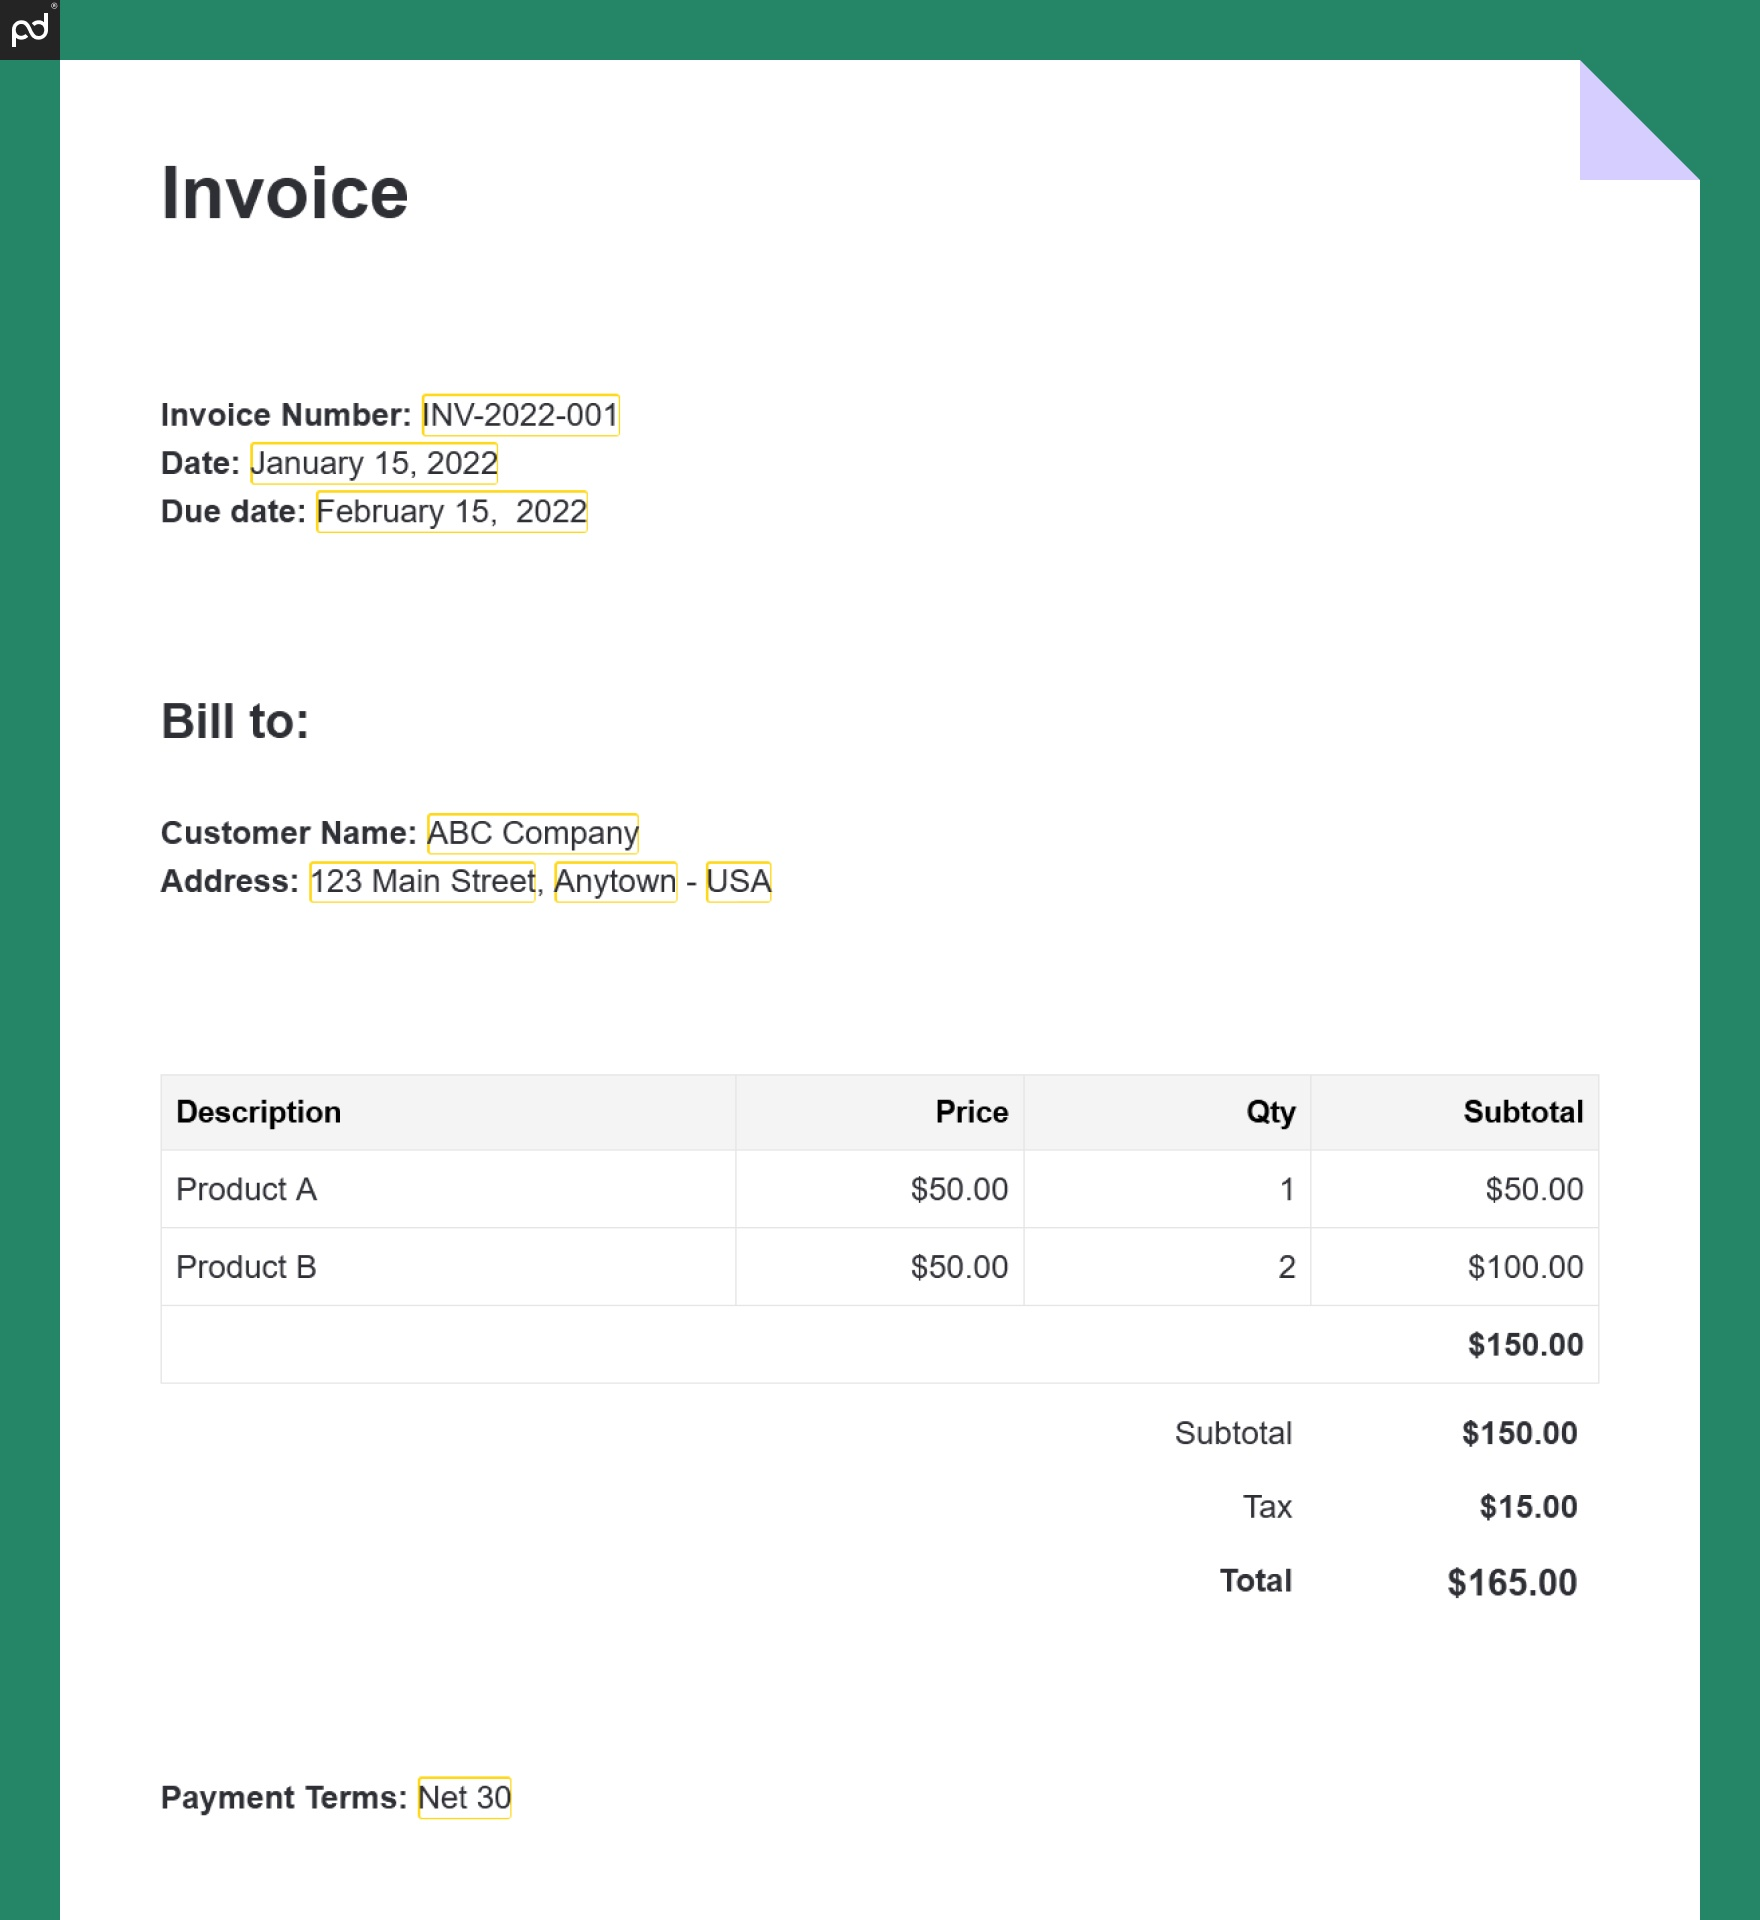

In [ ]:
Image(filename='../input_invoice_4.jpg')

In [ ]:
# Example run
data = process_data_and_invoke_realtime_endpoint(
    pdf_file='../input_invoice_4.jpg',
    task='<INVOICE_KIE>'
)
data

{'text': {'invoice_date': 'February 15, 2022',
  'invoice_number': 'NV-2022-001',
  'due_date': 'February 15, 2022',
  'billing_address': '123 Main Street, Anytown, USA',
  'vendor': 'ABC Company',
  'customer': 'ABC Company',
  'total_amount': '$165.00',
  'tax_amount': '$15.00'}}

#### Example 4 - Extract Medical Invoice Data

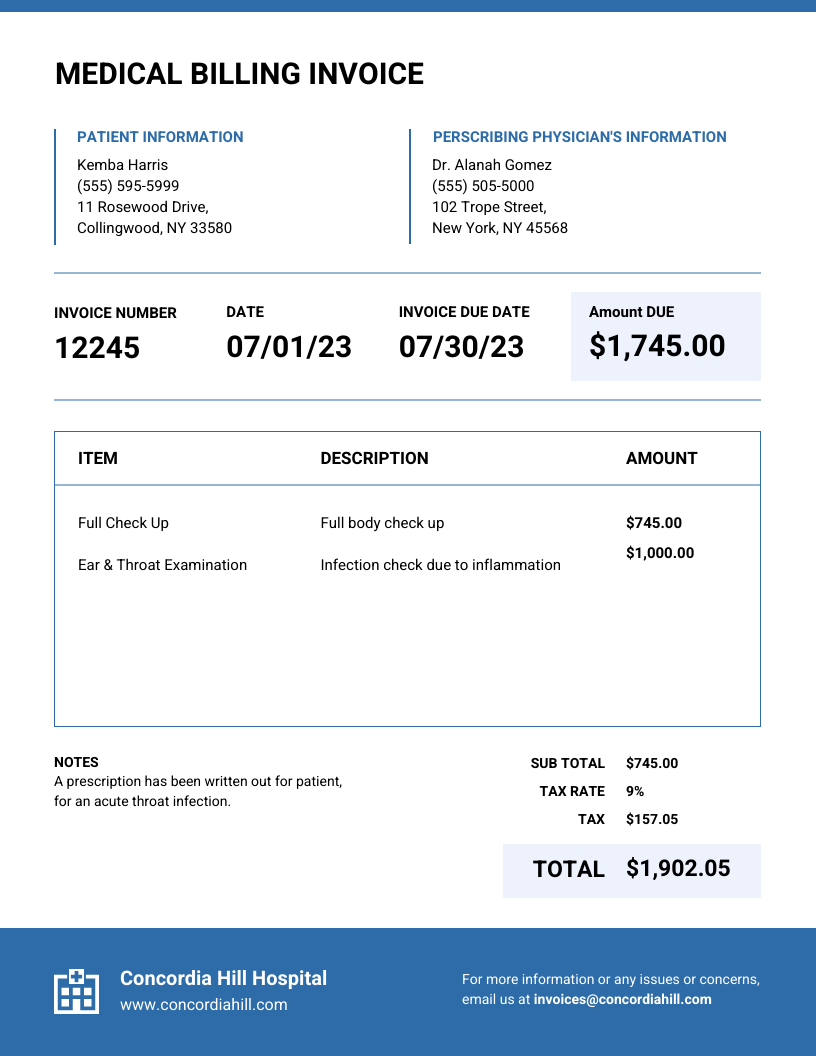

In [ ]:
Image(filename='../input_invoice_5.png')

In [ ]:
# Example run
data = process_data_and_invoke_realtime_endpoint(
    pdf_file='../input_invoice_5.png',
    task='<INVOICE_KIE>'
)
data

{'text': {'patient': 'Kemba Harris',
  'address_of_the_patient': '11 Rosewood Drive, 102 Trope Street, Collingwood, NY 33580',
  'physician': 'The physician is Dr. Alanah Gomez',
  'address_of_the_phyisician': '102 Trope Street, Collingwood, NY 33580',
  'name_of_the_hospital': 'Concordia Hill Hospital'}}

### C. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [ ]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

## 3. Batch inference

In [ ]:
validation_file_name1 = "input_1.pdf"
validation_file_name2 = "input_2.pdf"
validation_file_name3 = "../input_invoice_4.jpg"
validation_file_name4 = "../input_invoice_5.png"

validation_input_path = f"s3://{s3_bucket}/{model_name}/validation-input/batch"
validation_output_path = f"s3://{s3_bucket}/{model_name}/validation-output/batch"

input_dir = 'inputs/batch'
output_dir = 'outputs/batch'

os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def upload_pdf_to_s3(local_file_path):
    shutil.copy2(local_file_path, input_dir)
    base_file_name = os.path.basename(local_file_path)
    validation_input_file_path = f"{model_name}/validation-input/batch/{base_file_name}"
    s3_client.upload_file(local_file_path, s3_bucket, validation_input_file_path)

In [ ]:
upload_pdf_to_s3(validation_file_name1)
upload_pdf_to_s3(validation_file_name2)
upload_pdf_to_s3(validation_file_name3)
upload_pdf_to_s3(validation_file_name4)

In [ ]:
from sagemaker.transformer import Transformer
from sagemaker.session import Session

# ===== Configuration =====
batch_instance_type = "ml.c5.9xlarge"
batch_instance_count = 1

s3_prepared_prefix = f"{model_name}/prepared-input/batch"
validation_output_path = f"s3://{s3_bucket}/{model_name}/validation-output/batch"

# ===== Clients =====
sm_session = Session()

# ===== Input files and tasks =====
files_and_tasks = [
    ("input_1.pdf", "<OCR>"),
    ("input_2.pdf", "<OCR_WITH_REGION>"),
    ("../input_invoice_4.jpg", "<INVOICE_KIE>"),
    ("../input_invoice_5.png", "<INVOICE_KIE>"),
]

# ===== Prepare input JSONs and upload to S3 =====
for local_file, task in files_and_tasks:
    base_name = os.path.basename(local_file)
    local_path = os.path.join(input_dir, base_name)
    shutil.copy2(local_file, local_path)

    with open(local_path, "rb") as f:
        encoded_data = base64.b64encode(f.read()).decode("utf-8")

    payload = {"data": encoded_data, "task": task}
    json_file = os.path.join(input_dir, f"{base_name}.json")
    with open(json_file, "w") as f_out:
        json.dump(payload, f_out)

    s3_key = f"{s3_prepared_prefix}/{base_name}.json"
    s3_client.upload_file(json_file, s3_bucket, s3_key)

# ===== Transformer =====
transformer = Transformer(
    model_name=model_name,
    instance_count=batch_instance_count,
    instance_type=batch_instance_type,
    strategy="SingleRecord",
    output_path=validation_output_path,
    accept="application/json",
    sagemaker_session=sm_session,
)

s3_prepared_uri = f"s3://{s3_bucket}/{s3_prepared_prefix}/"
transformer.transform(s3_prepared_uri, content_type="application/json")
transformer.wait()

# ===== Download outputs =====
batch_output_prefix = f"{model_name}/validation-output/batch"
s3_objects = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=batch_output_prefix)

for obj in s3_objects.get("Contents", []):
    local_path = os.path.join(output_dir, os.path.basename(obj["Key"]))
    s3_client.download_file(s3_bucket, obj["Key"], local_path)

In [ ]:
def prepare_json_input(file_path, task):
    with open(file_path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")
    payload = {"data": encoded, "task": task}

    json_filename = os.path.splitext(os.path.basename(file_path))[0] + ".json"
    json_path = os.path.join("json-inputs", json_filename)
    os.makedirs(os.path.dirname(json_path), exist_ok=True)

    with open(json_path, "w") as f:
        json.dump(payload, f)

    return json_path

In [ ]:
def display_batch_output(file_basename):
    # List all objects under transformer output prefix
    parsed_url = urlparse(transformer.output_path)
    prefix = parsed_url.path.lstrip("/")

    response_list = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=prefix)
    if 'Contents' not in response_list:
        raise ValueError("No objects found in S3 output path")

    # Match by filename without directory path
    matching_objects = [
        obj['Key'] for obj in response_list['Contents']
        if os.path.basename(file_basename) in obj['Key']
    ]
    if not matching_objects:
        raise ValueError(f"No object found for file '{file_basename}' in S3 output path")

    file_key = matching_objects[0]
    response = s3_client.get_object(Bucket=s3_bucket, Key=file_key)
    data = json.loads(response["Body"].read().decode("utf-8"))

    print(json.dumps(data, indent=4))

In [ ]:
display_batch_output(validation_file_name1)

{
    "pages": [
        {
            "page": 1,
            "text": {
                "<OCR>": "This is an example of handwritten\nbest.\nLet's oe check the performance!\nI hope it will be awesome.\n"
            }
        },
        {
            "page": 2,
            "text": {
                "<OCR>": "STARBUCKS Store #10208\n11302 Euclid Avenue\nCleveland, OH (216) 229-0749\nCHK 664290\n12/07/2014 06:43 PM\n1912003 Drawer: 2 Reg: 2\nVt Pep Mocha\n4.95\nShux Card\n4,95\nXXXXXXXXXXXXX3228\nSubtotal\n$4.96\nTotal\n$44.95.\nChange Due\n$0.00\nCheck Closed\n12 /07/ 2014 06: 43 PM\nSBUX Card x3228 New Balance: 37.45\nCard is registertal.\n"
            }
        }
    ]
}


In [ ]:
display_batch_output(validation_file_name2)

{
    "pages": [
        {
            "page": 1,
            "text": {
                "<OCR_WITH_REGION>": {
                    "quad_boxes": [
                        [
                            583.2124633789062,
                            122.44999694824219,
                            1815.1124267578125,
                            122.44999694824219,
                            1815.1124267578125,
                            237.14999389648438,
                            583.2124633789062,
                            237.14999389648438
                        ],
                        [
                            653.5374755859375,
                            261.9499816894531,
                            1701.137451171875,
                            271.25,
                            1701.137451171875,
                            379.75,
                            653.5374755859375,
                            370.4499816894531
                        ],
             

In [ ]:
display_batch_output(validation_file_name3)

{
    "text": {
        "invoice_date": "February 15, 2022",
        "invoice_number": "NV-2022-001",
        "due_date": "February 15, 2022",
        "billing_address": "123 Main Street, Anytown, USA",
        "vendor": "ABC Company",
        "customer": "ABC Company",
        "total_amount": "$165.00",
        "tax_amount": "$15.00"
    }
}


In [ ]:
display_batch_output(validation_file_name4)

{
    "text": {
        "patient": "Kemba Harris",
        "address_of_the_patient": "11 Rosewood Drive, 102 Trope Street, Collingwood, NY 33580",
        "physician": "The physician is Dr. Alanah Gomez",
        "address_of_the_phyisician": "102 Trope Street, Collingwood, NY 33580",
        "name_of_the_hospital": "Concordia Hill Hospital"
    }
}


In [ ]:
model.delete_model()

### Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model.

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

